In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, sampler
import torchvision
from torchvision import transforms
import albumentations as A
from PIL import Image
import numpy as np
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import os
from albumentations.pytorch import ToTensorV2
from utils import calc_metric, write_results,list_to_cuda, eval_model, train_one_epoch
from fusion_layer import FusionLayer
from torchvision.models import resnet18, ResNet18_Weights


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:

def get_data_transforms():
    """
    Returns proper data augmentation for the method given as parameter.
    """
    
    #mean and std for imagenet
    mean = [0.485, 0.456, 0.406]
    std = [0.228, 0.224, 0.225]
    
    normalize = A.Normalize(mean=mean, std=std)
    #albumentations on training data
    train_trans = [

                  A.Resize(height = 1934//4, width=2576//4),
                  A.HorizontalFlip(),
                  A.VerticalFlip(), 
                  A.Rotate(10),
                  A.Blur(blur_limit=11), 
                  A.ColorJitter(brightness=1,contrast=0.5,saturation=0.25,hue=0.05),
                  A.RandomResizedCrop(size=(224,224), scale=(0.75, 1.0)), 
                  normalize,
                  ToTensorV2()]
    #albumentations on validation data
    val_trans =  [
                  A.Resize(height = 224, width=224),
                  normalize,
                  ToTensorV2()]
    #albumentations on testing data
    test_trans =  [
                   A.Resize(height=224, width=224),
                   normalize,
                   ToTensorV2()]


    #dict to store the transformations for each step
    data_transforms = {
        'train': A.Compose(train_trans),
        'val': A.Compose(val_trans),
        'test': A.Compose(test_trans),
    }
    
    return data_transforms

In [3]:
class PapilaDataset(torch.utils.data.Dataset):
    def __init__(self, labels_csv, prefix=None, transforms=None):
        super(PapilaDataset, self).__init__()
        self.labels_csv = labels_csv
        self.augmentations = transforms
        print(labels_csv)
        self.csv = pd.read_csv(labels_csv,index_col=False) 
        self.csv.reset_index(drop=True, inplace=True)
        
        self.class_counts = dict(self.csv['label'].value_counts())

        classes = list(self.csv['label'].unique())
        classes.sort()
        self.class_to_idx = {classes[i]: i for i in range(len(classes))}
        self.classes = classes

        print('Found {} images from {} classes.'.format(len(self.csv),
                                                        len(classes)))
        for class_name, idx in self.class_to_idx.items():
            n_images = dict(self.csv['label'].value_counts())
            print("    Class '{}' ({}): {} images.".format(
                class_name, idx, n_images[class_name]))
    
    def __len__(self):
        """
        returns the length of the dataframe
        """
        return len(self.csv['img_name'])
    
    def __getitem__(self, idx):
        """
        returns the image, appropriate metadata, and disease label in the row specified by idx
        """
        img_path = list(self.csv['img_name'])[idx]
        img = Image.open(img_path).convert("RGB")        
        img2 = np.array(img)
        label = torch.tensor(int(list(self.csv['label'])[idx]))
        if self.augmentations is not None:
            img = self.augmentations(image=img2)["image"]
            
        #Extracting metadata features
        age = list(self.csv['qAge'])[idx]
        age =  torch.tensor(int(age))
        dioptre = list(self.csv['qdioptre_2'])[idx]
        dioptre =  torch.tensor(int(dioptre))
        pneumatic = list(self.csv['qPneumatic'])[idx]
        pneumatic =  torch.tensor(int(pneumatic))
        gender = list(self.csv['Gender'])[idx]
        gender =  torch.tensor(int(gender))
        pachymetry = list(self.csv['qPachymetry'])[idx]
        pachymetry =  torch.tensor(int(pachymetry))
        axial_length = list(self.csv['qAxial_Length'])[idx]
        axial_length =  torch.tensor(int(axial_length))
        phakic = list(self.csv['phakic'])[idx]
        phakic =  torch.tensor(int(phakic))
         
        metadata = (age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic)
        return img, metadata, label    
     

In [6]:
data_transforms = get_data_transforms()
batch_size = 32
batch_size_test = 32
lr = 0.0001 

#Creating train validation and test sets, change path accordingly for each cross validation split
papila_train_ds = PapilaDataset('C:\\Users\\preet\\Documents\\PAPILA\\PAPILA\\DB\\ClinicalData\\papila2_train_1.csv',transforms=data_transforms['train'])
papila_val_ds  =  PapilaDataset('C:\\Users\\preet\\Documents\\PAPILA\\PAPILA\\DB\\ClinicalData\\papila2_val_1.csv',transforms=data_transforms['val'])
papila_test_ds  =  PapilaDataset('C:\\Users\\preet\\Documents\\PAPILA\\PAPILA\\DB\\ClinicalData\\papila2_test.csv',transforms=data_transforms['test'])

#Creating the dataloaders
train_loader = DataLoader(papila_train_ds, batch_size=batch_size, shuffle=True,
                          pin_memory=True, num_workers=0)

test_loader = DataLoader(papila_test_ds, batch_size=batch_size, shuffle=False,
                          pin_memory=True, num_workers=0)

val_loader = DataLoader(papila_val_ds, batch_size=batch_size, shuffle=False,
                          pin_memory=True, num_workers=0)

#Models

#baseline approach (no metadata information)
class resnet_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.img_emb_dim = 256
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,self.img_emb_dim)
        self.classifier = nn.Linear(self.img_emb_dim, 3)
        self.enable_gates = enable_gates
     
    def forward(self, x, x_metadata):
        (age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic) = x_metadata
        x=self.encoder(x)
        y= self.classifier(x)
        return y
        
#concatenation approach
class resnet_concat_model(torch.nn.Module):
    def __init__(self):
        super(resnet_concat_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.img_emb_dim = 256
        self.emb_dim = 16
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,self.img_emb_dim)

        self.age_emb = nn.Embedding(15,  self.emb_dim)
        self.dioptre_emb = nn.Embedding(16,  self.emb_dim)
        self.pneumatic_emb = nn.Embedding(13,  self.emb_dim)
        self.gender_emb = nn.Embedding(2,  self.emb_dim)
        self.pachymetry_emb = nn.Embedding(14,  self.emb_dim)
        self.axial_length_emb = nn.Embedding(15,  self.emb_dim)
        self.phakic_emb = nn.Embedding(2,  self.emb_dim)
        self.classifier = nn.Linear(self.img_emb_dim+7*self.emb_dim, 3)
 

    def forward(self, x, x_metadata):
        (age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic) = x_metadata
        x=self.encoder(x)
        x1 = self.age_emb(age)
        x2 = self.dioptre_emb(dioptre)
        x3 = self.pneumatic_emb(pneumatic)
        x4 = self.gender_emb(gender)
        x5 = self.pachymetry_emb(pachymetry)
        x6 = self.axial_length_emb(axial_length)
        x7 = self.phakic_emb(phakic)

        x_all = torch.cat((x,x1,x2,x3,x3,x5,x6,x7),dim=1)
        y = self.classifier(x_all)
        return y
        

#Metanet architecture
class resnet_metanet_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_metanet_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.img_emb_dim = 256
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,self.img_emb_dim)
        self.linear = nn.Linear(15+16+13+2+14+15+2,self.img_emb_dim)
        self.classifier = nn.Linear(self.img_emb_dim, 3)
        self.enable_gates = enable_gates
        
    def forward(self, x, x_metadata):
        (age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic) = x_metadata
        x=self.encoder(x)
        age = torch.nn.functional.one_hot(age, num_classes=15)
        dioptre = torch.nn.functional.one_hot(dioptre, num_classes=16)
        pneumatic = torch.nn.functional.one_hot(pneumatic, num_classes=13)
        gender = torch.nn.functional.one_hot(gender, num_classes=2)
        pachymetry = torch.nn.functional.one_hot(pachymetry, num_classes=14)
        axial_length = torch.nn.functional.one_hot(axial_length, num_classes=15)
        phakic = torch.nn.functional.one_hot(phakic, num_classes=2)

        x_meta = torch.cat((age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic),dim=1)
        y = self.linear(x_meta.float())
        y = F.sigmoid(y)
        x = x*y
        y= self.classifier(x)
        return y

#Metablock architecture
class resnet_metablock_model(torch.nn.Module):
    def __init__(self, enable_gates=False):
        super(resnet_metablock_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.img_emb_dim = 256
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,self.img_emb_dim)
        self.linear1 = nn.Linear(15+16+13+2+14+15+2,self.img_emb_dim)
        self.linear2 = nn.Linear(15+16+13+2+14+15+2,self.img_emb_dim)
        self.classifier = nn.Linear(self.img_emb_dim, 3)
        self.enable_gates = enable_gates

    def forward(self, x, x_metadata):
        (age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic) = x_metadata
        x=self.encoder(x)
        age = torch.nn.functional.one_hot(age, num_classes=15)
        dioptre = torch.nn.functional.one_hot(dioptre, num_classes=16)
        pneumatic = torch.nn.functional.one_hot(pneumatic, num_classes=13)
        gender = torch.nn.functional.one_hot(gender, num_classes=2)
        pachymetry = torch.nn.functional.one_hot(pachymetry, num_classes=14)
        axial_length = torch.nn.functional.one_hot(axial_length, num_classes=15)
        phakic = torch.nn.functional.one_hot(phakic, num_classes=2)

        x_meta = torch.cat((age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic),dim=1)
        y1 = self.linear1(x_meta.float())
        y2 = self.linear2(x_meta.float())
        x = F.sigmoid(F.tanh(x*y1)+y2)
        y= self.classifier(x)
        return y
      
    

#Metafusion novel approach  
class meta_fusion_model(torch.nn.Module):
    def __init__(self):
        super(meta_fusion_model, self).__init__()
        self.encoder =resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
        self.img_emb_dim = 256
        self.emb_dim = 16
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features,self.img_emb_dim)

  
        self.age_emb = nn.Embedding(15,  self.emb_dim)
        self.dioptre_emb = nn.Embedding(16,  self.emb_dim)
        self.pneumatic_emb = nn.Embedding(13,  self.emb_dim)
        self.gender_emb = nn.Embedding(2,  self.emb_dim)
        self.pachymetry_emb = nn.Embedding(14,  self.emb_dim)
        self.axial_length_emb = nn.Embedding(15,  self.emb_dim)
        self.phakic_emb = nn.Embedding(2,  self.emb_dim)
        self.classifier = nn.Linear(self.img_emb_dim+7*self.emb_dim, 3)
        
        self.age_gate1 = FusionLayer(self.emb_dim, self.img_emb_dim)
        self.dioptre_gate1 = FusionLayer(self.emb_dim, self.img_emb_dim)
        self.pneumatic_gate1 = FusionLayer(self.emb_dim, self.img_emb_dim)
        self.gender_gate1 = FusionLayer(self.emb_dim, self.img_emb_dim)
        self.pachymetry_gate1 = FusionLayer(self.emb_dim, self.img_emb_dim)
        self.axial_length_gate1 = FusionLayer(self.emb_dim, self.img_emb_dim)
        self.phakic_gate1 = FusionLayer(self.emb_dim, self.img_emb_dim)
        self.image_gate1 = FusionLayer(self.img_emb_dim, self.emb_dim*7)  
    
    def forward(self, x, x_metadata):
        (age, dioptre, pneumatic,gender,pachymetry,axial_length, phakic) = x_metadata
        x=self.encoder(x)
        x_age_emb = self.age_emb(age)
        x_dioptre_emb = self.dioptre_emb(dioptre)
        x_pneumatic_emb = self.pneumatic_emb(pneumatic)
        x_gender_emb = self.gender_emb(gender)
        x_pachymetry_emb = self.pachymetry_emb(pachymetry)
        x_axial_length_emb = self.axial_length_emb(axial_length)
        x_phakic_emb = self.phakic_emb(phakic)

        #modify metadata
        x_all = torch.cat((x_age_emb, x_dioptre_emb, x_pneumatic_emb,x_gender_emb,x_pachymetry_emb,x_axial_length_emb, x_phakic_emb),dim=1)
        x_all = x_all + self.image_gate1(x_all,x)

        #modify image
        x1 = x + self.age_gate1(x, x_age_emb)
        x2 = x1 + self.dioptre_gate1(x, x_dioptre_emb)
        x3 = x2 + self.pneumatic_gate1(x, x_pneumatic_emb)
        x4 = x3 + self.gender_gate1(x, x_gender_emb)
        x5 = x4 + self.pachymetry_gate1(x, x_pachymetry_emb)
        x6 = x5 + self.axial_length_gate1(x, x_axial_length_emb)
        x7 = x6 + self.phakic_gate1(x, x_phakic_emb)

        # Final classifier
        x_out = torch.cat((x7,x_all),dim=1)
        y = self.classifier(x_out)
        return y

C:\Users\preet\Documents\PAPILA\PAPILA\DB\ClinicalData\papila2_train_1.csv
Found 264 images from 3 classes.
    Class '0' (0): 189 images.
    Class '1' (1): 47 images.
    Class '2' (2): 28 images.
C:\Users\preet\Documents\PAPILA\PAPILA\DB\ClinicalData\papila2_val_1.csv
Found 88 images from 3 classes.
    Class '0' (0): 63 images.
    Class '1' (1): 12 images.
    Class '2' (2): 13 images.
C:\Users\preet\Documents\PAPILA\PAPILA\DB\ClinicalData\papila2_test.csv
Found 88 images from 3 classes.
    Class '0' (0): 64 images.
    Class '1' (1): 13 images.
    Class '2' (2): 11 images.


C:\ProgramData\Anaconda3\envs\pt21p\lib\site-packages\pydantic\main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:21<00:00,  2.40s/it]


LR [9.990232305719945e-05]
Trn Loss 0.90393853
Balanced ACC 0.3117659199219483
Confusion matrix [[166   9  14]
 [ 42   1   4]
 [ 27   0   1]]
Acc 0.6363636363636364
Saving model for epoch 0


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.28s/it]


Loss 0.7497843
Balanced ACC 0.3611111111111111
Confusion matrix [[63  0  0]
 [11  1  0]
 [13  0  0]]
Acc 0.7272727272727273


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.30s/it]


Loss 0.7569514
Balanced ACC 0.358974358974359
Confusion matrix [[64  0  0]
 [12  1  0]
 [ 9  2  0]]
Acc 0.7386363636363636
[0.90393853]
['test_acc', 'test_ba', 'test_loss', 'trn_acc', 'trn_ba', 'trn_loss', 'val_acc', 'val_ba', 'val_loss']


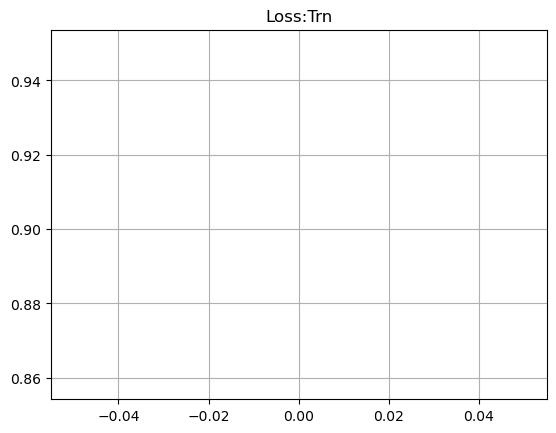

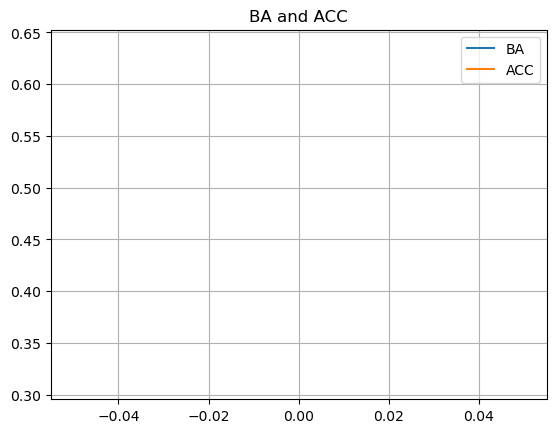

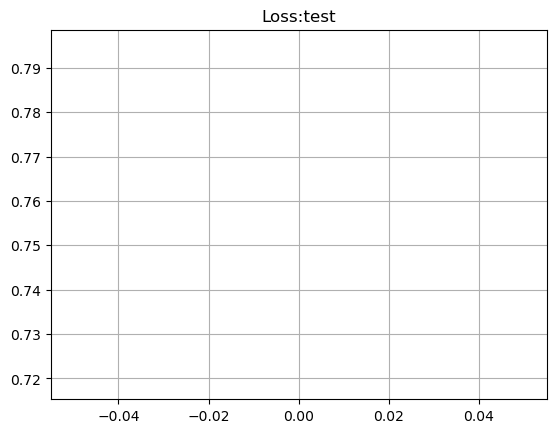

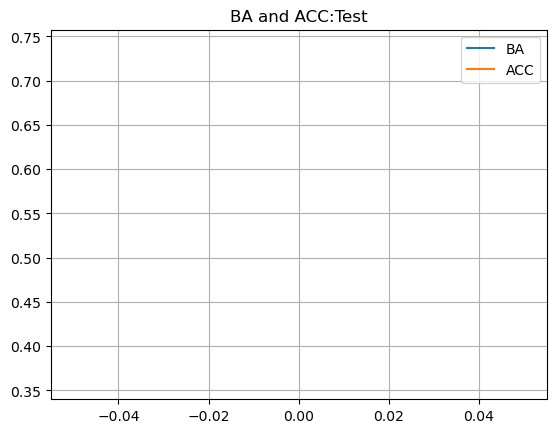

KeyboardInterrupt: 

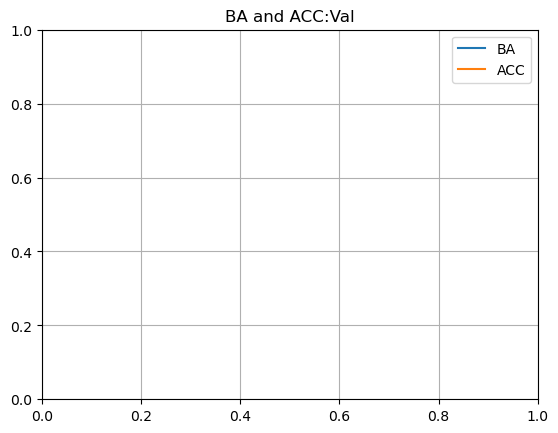

In [7]:
# Train loop
exp_base_dir = 'results_papilla_5' #Change accordingly with each cross validation - stores training, validation, testing information
for model_id in range(1,6):
    #Select specific model type
    if model_id == 1:
        model = resnet_model().cuda()
    if model_id == 2:    
        model = resnet_concat_model().cuda()
    if model_id == 3:    
        model = resnet_metanet_model().cuda()
    if model_id == 4:
        model = resnet_metablock_model().cuda()
    if model_id == 5:
        model = meta_fusion_model().cuda()
        
    #Initialize optimizer, scheduler, number of epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # weight_decay=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6) # Adam
    start_epoch=0
    num_epochs = 50

    # Initialize lists to store epoch information
    model.cuda()
    loss_list =[]
    ba_list=[]
    acc_list=[]
    ba_test_list=[]
    acc_test_list=[]
    loss_test_list =[]
    ba_val_list=[]
    acc_val_list=[]
    loss_val_list =[]
    exp_dir = exp_base_dir + "\\exp_"+str(model_id)+"\\"
    
    if not os.path.exists(exp_dir):
        os.mkdir(exp_dir)
        
    for epoch in range(start_epoch,start_epoch+num_epochs):
        model.train() 
        #Call the train_one_epoch function 
        mean_loss, ba,acc = train_one_epoch(model, optimizer, scheduler, train_loader)          
        model_file_name = exp_dir + "resnet_model_epoch_"+str(epoch)+".pth"
        print("Saving model for epoch", epoch)
        torch.save(model.cpu().state_dict(), model_file_name)
        loss_list.append(mean_loss)
        ba_list.append(ba)
        acc_list.append(acc)
        model.cuda()
        ba, acc, loss = eval_model(model, val_loader)
        ba_val_list.append(ba)
        acc_val_list.append(acc)
        loss_val_list.append(loss)
        ba_test, acc_test, loss_test = eval_model(model, test_loader)
        ba_test_list.append(ba_test)
        acc_test_list.append(acc_test)
        loss_test_list.append(loss_test)
    write_results(exp_dir,loss_list, ba_list, acc_list, loss_val_list, ba_val_list, acc_val_list, loss_test_list, ba_test_list, acc_test_list)        
                
